# Document Clustering of Email data using Doc2Vec and K-means models

The email documents were obtained from the Enron Email Dataset on Kaggle - https://www.kaggle.com/wcukierski/enron-email-dataset

In [1]:
import re
import os, sys, email
import numpy as np
import pandas as pd
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
emails = pd.read_csv('emails.csv', nrows=20000)
emails.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
emails['message'][0]

"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n "

In [4]:
## This code in this and next cell is taken from the from Explore Enron notebook by Zichen Wang
## Helper functions

def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

## Data Preparation

In [5]:
messages = list(map(email.message_from_string, emails['message']))
emails.drop('message', axis=1, inplace=True)
keys = messages[0].keys()

for key in keys:
    emails[key] = [doc[key] for doc in messages]
    
# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))

# Extracting the subject and content of each email as a document
documents = emails['Subject'] + " " + emails['content']

In [6]:
documents[0 : 5]

0                            Here is our forecast\n\n 
1    Re: Traveling to have a business meeting takes...
2              Re: test test successful.  way to go!!!
3     Randy,\n\n Can you send me a schedule of the ...
4        Re: Hello Let's shoot for Tuesday at 11:45.  
dtype: object

## Data Preprocessing

Preprocessing the documents involves the following tasks:

1. Tokenization
2. Removal of stop words
3. Removal of words containing special characters
4. Removal of URLs
5. Removal of email addresses
6. Removal of HTML tags
7. Removal of tokens having length < 2 


In [7]:
def preprocessing(documents):
    
    tokenizer = RegexpTokenizer(r'\w+')

    for i in range(len(documents)):
        filtered_words = []
        tokens = tokenizer.tokenize(documents[i])
        
        words = [word.lower() for word in tokens]
        
        for word in words:
            if word.isalnum() and (word not in stop_words) and len(word) > 1 and ('http' not in word) and ('@' not in word) and ('<.*?>' not in word):
                filtered_words.append(word)
        
        stemmed_words = [porter_stemmer.stem(word) for word in filtered_words]
        
        documents[i] = stemmed_words
        
    return documents

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

preprocessed_documents = preprocessing(documents)

In [9]:
preprocessed_documents[0 : 5]

0                                           [forecast]
1    [travel, busi, meet, take, fun, trip, especi, ...
2                       [test, test, success, way, go]
3    [randi, send, schedul, salari, level, everyon,...
4                 [hello, let, shoot, tuesday, 11, 45]
dtype: object

## Tagging the documents

In [10]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_documents)]

In [11]:
documents[0 : 5]

[TaggedDocument(words=['forecast'], tags=[0]),
 TaggedDocument(words=['travel', 'busi', 'meet', 'take', 'fun', 'trip', 'especi', 'prepar', 'present', 'would', 'suggest', 'hold', 'busi', 'plan', 'meet', 'take', 'trip', 'without', 'formal', 'busi', 'meet', 'would', 'even', 'tri', 'get', 'honest', 'opinion', 'whether', 'trip', 'even', 'desir', 'necessari', 'far', 'busi', 'meet', 'think', 'would', 'product', 'tri', 'stimul', 'discuss', 'across', 'differ', 'group', 'work', 'often', 'present', 'speak', 'other', 'quiet', 'wait', 'turn', 'meet', 'might', 'better', 'held', 'round', 'tabl', 'discuss', 'format', 'suggest', 'go', 'austin', 'play', 'golf', 'rent', 'ski', 'boat', 'jet', 'ski', 'fli', 'somewher', 'take', 'much', 'time'], tags=[1]),
 TaggedDocument(words=['test', 'test', 'success', 'way', 'go'], tags=[2]),
 TaggedDocument(words=['randi', 'send', 'schedul', 'salari', 'level', 'everyon', 'schedul', 'group', 'plu', 'thought', 'chang', 'need', 'made', 'patti', 'exampl', 'phillip'], tags=[

## Implementing the Doc2vec model

In [23]:
doc2vec_model = Doc2Vec(documents, vector_size=2000, window=10, min_count=500, workers=7, dm=1, alpha=0.025, min_alpha=0.001)


In [24]:
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [25]:
doc2vec_model.docvecs.most_similar(4)

[(2997, 0.9078291654586792),
 (1209, 0.8803160190582275),
 (234, 0.7829979062080383),
 (834, 0.7672679424285889),
 (11444, 0.7588800191879272),
 (2640, 0.7540549039840698),
 (828, 0.7360304594039917),
 (10712, 0.7350432276725769),
 (8619, 0.7205708622932434),
 (2646, 0.7185483574867249)]

## Clustering the documents using K-means

In [26]:
kmeans = KMeans(n_clusters=4, init="k-means++").fit(doc2vec_model.docvecs.vectors_docs)

In [27]:
labels = kmeans.labels_.tolist()
np.unique(labels)

array([0, 1, 2, 3])

## Plotting the clustering results

Using PCA to reduce the dimensionality of the documents to a 2D space inorder to plot the same.

In [28]:
pca = PCA(n_components=2).fit(doc2vec_model.docvecs.vectors_docs)
datapoint = pca.transform(doc2vec_model.docvecs.vectors_docs)

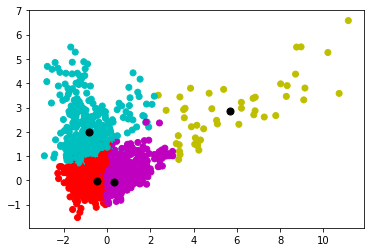

In [29]:
cluster_colors = ['c', 'm', 'y', 'r']

color = [cluster_colors[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

# Black spots indicate the cluster centers
centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], s=50, c='#000000') 
plt.show()